In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse
from sklearn import metrics
from scipy.linalg import sqrtm, inv
import plotly.graph_objects as go
import scipy.linalg
import matplotlib.transforms as transforms
from scipy.spatial.transform import Rotation as Rot
%matplotlib inline

In [2]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.power(np.diag([1.0, 1.0]),2)  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.power(np.diag([0.5, 0.5]),2)
Input_Noise = np.power(np.diag([1.0, np.deg2rad(30.0)]),2)

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show = False

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]], dtype=float)

In [3]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [4]:
def observation(xTrue, xd, u):
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)

    # add noise to input
    ud = u + Input_Noise @ np.random.randn(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [5]:
def motion_model(x, u):
    phi = x[2,0]
    
    F = np.array([[1, 0, 0, 0,],
                  [0, 1, 0, 0,],
                  [0, 0, 1, 0,],
                  [0, 0, 0, 0,]], dtype=float)
    
    B = np.array([[np.cos(phi) * dt, 0],
                  [np.sin(phi) * dt, 0],
                  [0, dt],
                  [1, 0]], dtype=float)
    
    x1 = F @ x + B @ u

    return x1

In [6]:
def observation_model(x):
    H = np.array([
        [1,0,0,0],
        [0,1,0,0]
    ])
    
    z = H @ x

    return z

In [7]:
def jacobF(x, u):
    v = u[0, 0]
    phi = x[2, 0]
    
    jF = np.array([[1, 0, -v * np.sin(phi) * dt, np.cos(phi) * dt],
                   [0, 1, v * np.cos(phi) * dt, np.sin(phi) * dt],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]], dtype=float)
    
    return jF

In [8]:
def jacobH():
    jH = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0]], dtype=float)

    return jH

In [9]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [10]:
def ekf_estimation(xEst, PEst, z, u):
    #  Predict
    xPred = motion_model(xEst, u)
    jF = jacobF(xEst, u)
    PPred = jF @ PEst @ jF.T + Q

    #  Update
    jH = jacobH()
    zPred = observation_model(xPred)
    y = z - zPred
    S = jH @ PPred @ jH.T + R
    K = PPred @ jH.T @ np.linalg.inv(S)
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jH) @ PPred
    return xEst, PEst


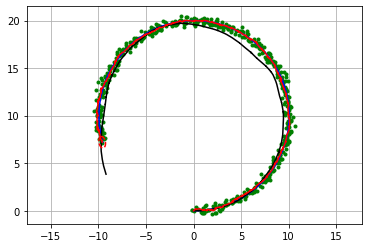

In [29]:
    time = 0.0

    # State Vector [x y yaw v]'
    xEstEkf = np.zeros((4, 1))
    xTrueEkf = np.zeros((4, 1))
    PEstEkf = np.eye(4)

    xDREkf = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEstEkf = xEstEkf
    hxTrueEkf = xTrueEkf
    hxDREkf = xTrueEkf
    hzEkf = np.zeros((2, 1))
    fig = plt.figure()
    while SIM_TIME >= time:
        time += dt
        u = calc_input()

        xTrueEkf, zEkf, xDREkf, ud = observation(xTrueEkf, xDREkf, u)

        xEstEkf, PEstEkf = ekf_estimation(xEstEkf, PEstEkf, zEkf, ud)

        # store data history
        hxEstEkf = np.hstack((hxEstEkf, xEstEkf))
        hxDREkf = np.hstack((hxDREkf, xDREkf))
        hxTrueEkf = np.hstack((hxTrueEkf, xTrueEkf))
        hzEkf = np.hstack((hzEkf, zEkf))

        if show:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(hz[0, :], hz[1, :], ".g")
            plt.plot(hxTrue[0, :].flatten(),
                     hxTrue[1, :].flatten(), "-b")
            plt.plot(hxDR[0, :].flatten(),
                     hxDR[1, :].flatten(), "-k")
            plt.plot(hxEst[0, :].flatten(),
                     hxEst[1, :].flatten(), "-r")
            plot_covariance_ellipse(xEst, PEst)
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)
    plt.cla()
    plt.plot(hzEkf[0, :], hzEkf[1, :], ".g")
    plt.plot(hxTrueEkf[0, :].flatten(),
                    hxTrueEkf[1, :].flatten(), "-b")
    plt.plot(hxDREkf[0, :].flatten(),
                     hxDREkf[1, :].flatten(), "-k")
    plt.plot(hxEstEkf[0, :].flatten(),
                     hxEstEkf[1, :].flatten(), "-r")
    plot_covariance_ellipse(xEstEkf, PEstEkf)
    plt.axis("equal")
    plt.grid(True)
    fig.canvas.draw()
    plt.pause(0.001)


In [12]:
#  UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0

In [13]:
def generate_sigma_points(xEst, PEst, gamma):
    x_0 = xEst

    sigma_neg = xEst - gamma * sqrtm(PEst)
    sigma_pos = xEst + gamma * sqrtm(PEst)

    return np.concatenate((x_0, sigma_neg, sigma_pos), axis=1)

In [14]:
def predict_sigma_motion(sigma, u):
    return motion_model(sigma, u)
    
    #return sigmas

In [15]:
def predict_sigma_observation(sigma):
    return observation_model(sigma)
    
    #sigmas = observation_model(sigmas)

    #return sigmas

In [16]:
def calc_sigma_covariance(x, sigma, wc, Pi):
     return wc * (sigma-x) @ (sigma-x).T + Pi

In [17]:
def calc_pxz(sigma, x, z_sigma, zb, wc):
    # Calculate the covariance Pxz (P^xy_t|t-1) using wc, sigma (x^(i)_t|t-1),
    # x (xhat_t|t-1), z_sigma (y^(i)_t) and zb (yhat_t) and 
    
    return wc * (sigma-x) @ (z_sigma-zb).T

In [18]:
def observation_ukf(xTrue, xd, u):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)

    # add noise to input
    ud = u + Input_Noise @ np.random.randn(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [19]:
def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    #  Predict (UKF - time update)
    
    # Calculate the sigma-points using xExt (xhat_k|k) and PEst (P_k|k)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xEst, PEst, gamma)
    
    # Propagate the sigma-points (x^(i)_k+1|k = f(x^(i)_k|k , w^(i)_k)) 
    # using the sigma-points obtained in the previous calculus and u (ud = noisy u)
    # in def predict_sigma_motion
    sigma_propagated = predict_sigma_motion(sigma, u)

    # Calculate xPred (xhat_k+1|k) using wm and the propagated sigma-points 
    xPred = wm @ sigma_propagated.T  
    xPred = xPred.T
    
    # Calculate PPred (P_k|k-1) using xPred, the propagated sigma-points
    # wc and Q in def calc_sigma_covariance
    PPred = calc_sigma_covariance(xPred, sigma_propagated, wc, Q)

    
    #  Update (UKF - measurement update)
    
    # Calculate zPred (yhat_t) using xPred (xhat_k+1|k) in def observation_model
    zPred = observation_model(xPred)
    
    # Calculate y = (y_t - yhat_t) using z (y_t) and zPred (yhat_t)
    y = z - zPred
     
    # Calculate the sigma-points using xPred (xhat_k|k-1), PPred (P_k|k-1)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xPred, PPred, gamma)
    
    # Propagate the sigma-points z_sigma (y^(i)_t = h(x^(i)_t|t-1 , e^(i)_t)) 
    # using the propagated sigma-points in def predict_sigma_observation
    z_sigma = predict_sigma_observation(sigma)
    
    # Calculate zb (yhat_t) using wm and the propagated sigma-points z_sigma
    zb = wm @ z_sigma.T
    zb = zb.T
    
    # Calculate the sigma covariance, st (P^yy_t|t-1), using zb (yhat_t),
    # z_sigma (y^(i)_t), wc and R in def calc_sigma_covariance
    st = calc_sigma_covariance(zb, z_sigma, wc, R.T)
    
    # Calculate Pxz (P^xy_t|t-1) using sigma (x^(i)_t|t-1), xPred (xhat_t|t-1),
    # z_sigma (y^(i)_t), zb (yhat_t) and wc in def calc_pxz
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)    
    
    # Calculate K_t using Pxz (P^xy_t|t-1) and st (P^yy_t|t-1)
    K_t = Pxz @ inv(st.astype(float))
    
    # Update xEst (Xhat_t|t) using xPred (xhat_t|t-1), K_t and y (y_t - yhat_t)
    xEst = xPred + K_t @ y
    
    # Update PEst (P_t|t) using PPred (P_t|t-1), K_t and st (P^yy_t|t-1)
    PEst = PPred - K_t @ st @ K_t.T
    
    return xEst, PEst

In [20]:
def setup_ukf(nx):
    # calculate lambda
    lamb = ALPHA ** 2 * (nx + KAPPA) - nx
    # calculate the weights
    # w^(0)
    wm = [lamb / (lamb + nx)] # wm corresponds to w of the UKF Algorithm
    # wc^(0)
    wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * nx):
        # w^(+-i)
        wm.append(1.0 / (2 * (nx + lamb)))
        # wc^(+-i)
        wc.append(1.0 / (2 * (nx + lamb)))
    
    # define gamma
    gamma = math.sqrt(nx + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma

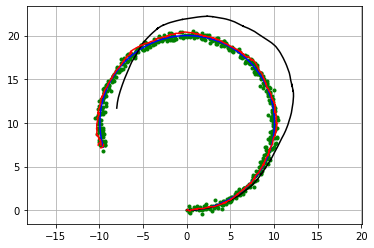

[[ 0.          0.        ]
 [-0.02302593 -0.06878606]
 [-0.03938922 -0.21826771]
 ...
 [-9.648661    7.42412175]
 [-9.61403682  7.26466772]
 [-9.56336143  7.14889529]]


In [21]:
nx = 4  # State Vector [x y yaw v]'
xEst = np.zeros((nx, 1))
xTrue = np.zeros((nx, 1))
PEst = np.eye(nx)
xDR = np.zeros((nx, 1))  # Dead reckoning

wm, wc, gamma = setup_ukf(nx)

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

time = 0.0
fig = plt.figure()

while SIM_TIME >= time:
    time += dt
    u = calc_input()

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ukf_estimation(xEst, PEst, z, ud, wm, wc, gamma)

        # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

plt.cla()
            
plt.plot(hz[0, :], hz[1, :], ".g")
plt.plot(np.array(hxTrue[0, :]).flatten(),
                     np.array(hxTrue[1, :]).flatten(), "-b")
plt.plot(np.array(hxDR[0, :]).flatten(),
                     np.array(hxDR[1, :]).flatten(), "-k")
plt.plot(np.array(hxEst[0, :]).flatten(),
                     np.array(hxEst[1, :]).flatten(), "-r")
plot_covariance_ellipse(xEst, PEst)
plt.axis("equal")
plt.grid(True)
fig.canvas.draw()
plt.pause(0.001)
print(hxEstEkf.T[:, :2])


In [22]:
print(hxEstEkf.T[:, :2])

[[ 0.          0.        ]
 [-0.02302593 -0.06878606]
 [-0.03938922 -0.21826771]
 ...
 [-9.648661    7.42412175]
 [-9.61403682  7.26466772]
 [-9.56336143  7.14889529]]


In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [24]:
xTrue = hxTrueEkf[0, :]
yTrue = hxTrueEkf[1, :]
xEstEkf = hxEstEkf[0, :]
yEstEkf = hxEstEkf[1, :]
difx = xTrue - xEstEkf
dify = yTrue - yEstEkf
error_Ekf = np.sqrt(difx ** 2 + dify ** 2)
sqrt_error_Ekf = np.sqrt(error_Ekf)
mean_Ekf = np.mean(error_Ekf)

In [25]:
xEst = hxEst[0, :]
yEst = hxEst[1, :]
difx = xTrue - xEst
dify = yTrue - yEst
error_Ukf = np.sqrt(difx ** 2 + dify ** 2)
sqrt_error_Ukf = np.sqrt(error_Ukf)
mean_Ukf = np.mean(error_Ukf)

In [26]:
xDREkf = hxDREkf[0, :]
yDREkf = hxDREkf[1, :]
xDRUkf = hxDR[0, :]
yDRUkf = hxDR[1, :]
difx = xTrue - xDREkf
dify = yTrue - yDREkf
error_DREkf = np.sqrt(difx ** 2 + dify ** 2)
sqrt_error_DREkf = np.sqrt(error_DREkf)
mean_DREkf = np.mean(error_DREkf)

In [27]:
difx = xTrue - xDRUkf
dify = yTrue - yDRUkf
error_DRUkf = np.sqrt(difx ** 2 + dify ** 2)
sqrt_error_DRUkf = np.sqrt(error_DRUkf)
mean_DRUkf = np.mean(error_DRUkf)

In [30]:
sqerrorekf = np.sqrt(rmse(hxEstEkf.T[:, :2], hxTrueEkf.T[:, :2]))
sqerrorukf = np.sqrt(rmse(hxEst.T[:, :2], hxTrue.T[:, :2]))
sqerrorDREkf = np.sqrt(rmse(hxTrueEkf.T[:, :2], hxDREkf.T[:, :2]))
sqerrorDRUkf = np.sqrt(rmse(hxTrue.T[:, :2], hxDR.T[:, :2]))

maeekf = (mae(hxEstEkf.T[:, :2], hxTrueEkf.T[:, :2]))
maeukf = (mae(hxEst.T[:, :2], hxTrue.T[:, :2]))
maeDrEkf = (mae(hxTrueEkf.T[:, :2],hxDREkf.T[:,:2]))
maeDrUkf = (mae(hxTrue.T[:, :2],hxDR.T[:,:2]))
conclusoes = np.asarray([mean_DREkf,sqerrorDREkf,maeDrEkf,mean_DRUkf,sqerrorDRUkf,maeDrUkf,mean_Ekf,sqerrorekf,maeekf,mean_Ukf,sqerrorukf,maeukf])
#print(conclusoes)
teste = np.reshape(conclusoes, (4,3))
colunas = ['Mean Error', 'Root Mean Square Deviation' , 'Mean Absolute Error']
indexe = ['DREkf','DRUkf','EKF', 'UKF']
df_conclusoes = pd.DataFrame(teste, index = indexe , columns = colunas)

df_conclusoes

,Mean Error,Root Mean Square Deviation,Mean Absolute Error
DREkf,2.877789,1.204874,1.174229
DRUkf,3.338325,1.637394,2.167778
EKF,0.150321,0.343277,0.092903
UKF,0.270165,0.458666,0.173330


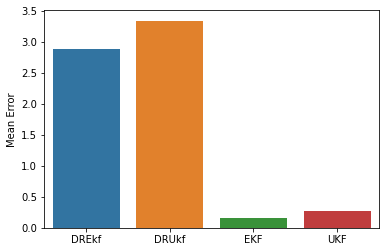

In [41]:
import seaborn as sns

ax = sns.barplot(x=indexe, y="Mean Error", data=df_conclusoes)

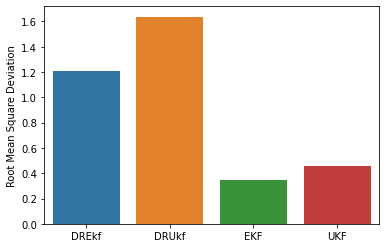

In [39]:
bx = sns.barplot(x=indexe, y="Root Mean Square Deviation", data=df_conclusoes)

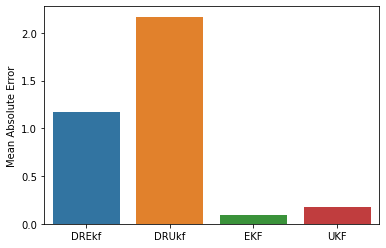

In [40]:
cx = sns.barplot(x=indexe, y="Mean Absolute Error", data=df_conclusoes)

<h1>Análise dos algoritmos</h1> 

<h2>Primeiro que tudo é necessário entender os algoritmos utilizados EKF e UKF</h2>

<h2> Extended Kalman Filter (EKF) </h2>

Este algoritmo aproxima o modelo com um modelo linear usando séries de Taylor antes de aplicar o KF normal.<br>
Os erros inerentes ao EKF vêm da linearização realizada para calcular a média e covariância de uma variável aleatória, que sofre uma transformação não-linear.<br>
O UKF previne estes erros.<br>
    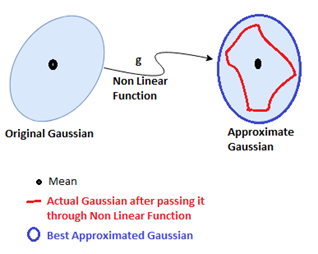
Temos um ponto para aproximar a Gaussiana.
    
<h2> Unscented Kalman Filter (UKF) </h2>

<br>O Unscented Kalman Filter é também um algoritmo para modelos não-lineares, contudo, são geralmente mais precisos, pois são gerados sigma-points e os seus respetivos pesos, que depois de sofrerem as transformações que o modelo real sofreu, acabam por ser mais próximos da realidade.</br>

-Vantagens:<br>
	-O erro esperado é menor que no EKF<br>
	-O novo filtro pode ser aplicado a funções não diferenciais<br>
	-Evita a derivação de matrizes Jacobianas<br>
     
Temos vários pontos (sigma points) para aproximar a gaussiana.<br>
Como damos pesos a estes pontos para dar preferência e melhorar a aproximação, são na verdade weighted sigma points.<br>

<b>Nota</b>: Código desenvolvido com base nestes <a href="https://github.com/AtsushiSakai/PythonRobotics/tree/master/Localization">notebooks</a>
<h1> Conclusões </h1>

- Foram aplicados três metodos de ánalise de erro o Mean Error o Root Mean Square Deviation e o Mean Absolute Error
- Analisando os gráficos de maneira mais cuidadosa conseguimos perceber que de forma mais evidente o dead reckoning em todos os   calculos de erro deram resultados elevadissimos, com valores sempre a superar 1
- No que toca aos dados dos algoritmos usados nomeadamente o EKF e o UKF ao contrário que é expectavel o Extended Kalman Filter   tem um erro inferior comparativamente ao Unscented Kalman Filter que por norma e segundo os conceitos de cada um não se devia   verificar, no entanto após alguma discussão com alguns colegas verifiquei que efetivamente o resultado do erro do Ukf é   superior apesar de não ser por muito.
- Se efetivamente houvesse o filtro de particulas segundo a logica seriam obtidos melhores resultados.
